In [1]:
from binance.client import Client
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import os

client = Client(tld='US')

In [5]:
# Adding more crypto currencies

univ = [
    'BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOGEUSDT','DOTUSDT',
    'LINKUSDT','LTCUSDT','TRXUSDT','MATICUSDT','AVAXUSDT','UNIUSDT',
    'XLMUSDT','ATOMUSDT','NEARUSDT','APTUSDT','BCHUSDT'
]

START_DATE = '2020-01-01'
END_DATE   = '2024-12-31'


def get_binance_px(symbol, freq='1d'):
    data = client.get_historical_klines(symbol, freq, START_DATE, END_DATE)
    columns = [
        'open_time','open','high','low','close','volume','close_time',
        'quote_volume','num_trades','taker_base_volume','taker_quote_volume','ignore'
    ]
    df = pd.DataFrame(data, columns=columns)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    df.set_index('open_time', inplace=True)
    df = df[['close']].astype(float)
    return df



os.makedirs('../data/raw', exist_ok=True)

for ticker in univ:
    df = get_binance_px(ticker)
    coin = ticker.replace('USDT','')
    df.to_csv(f'../data/raw/{coin}_USDT.csv')
    print(f'Saved {coin}')
    


Saved BTC
Saved ETH
Saved ADA
Saved BNB
Saved XRP
Saved DOGE
Saved DOT
Saved LINK
Saved LTC
Saved TRX
Saved MATIC
Saved AVAX
Saved UNI
Saved XLM
Saved ATOM
Saved NEAR
Saved APT
Saved BCH


In [9]:
all_coins = {}
for ticker in univ:
    coin = ticker.replace('USDT','')
    df = pd.read_csv(f'../data/raw/{coin}_USDT.csv', index_col='open_time', parse_dates=True)
    all_coins[coin] = df

print(all_coins.keys())
all_coins['BTC'].head()

dict_keys(['BTC', 'ETH', 'ADA', 'BNB', 'XRP', 'DOGE', 'DOT', 'LINK', 'LTC', 'TRX', 'MATIC', 'AVAX', 'UNI', 'XLM', 'ATOM', 'NEAR', 'APT', 'BCH'])


,close
open_time,
2020-01-01 00:00:00+00:00,7195.65
2020-01-02 00:00:00+00:00,6961.80
2020-01-03 00:00:00+00:00,7345.65
2020-01-04 00:00:00+00:00,7349.45
2020-01-05 00:00:00+00:00,7364.19


In [11]:
date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D', tz='UTC')
for coin in all_coins:
    all_coins[coin] = all_coins[coin].reindex(date_range).ffill()

prices = pd.concat([all_coins[c]['close'].rename(c) for c in all_coins], axis=1)
print(prices.head())

                               BTC     ETH      ADA      BNB      XRP  \
2020-01-01 00:00:00+00:00  7195.65  130.52  0.03346  13.6954  0.19301   
2020-01-02 00:00:00+00:00  6961.80  127.22  0.03272  13.0225  0.18762   
2020-01-03 00:00:00+00:00  7345.65  133.95  0.03403  13.6231  0.19320   
2020-01-04 00:00:00+00:00  7349.45  134.02  0.03441  13.7944  0.19277   
2020-01-05 00:00:00+00:00  7364.19  135.23  0.03455  14.0368  0.19462   

                               DOGE  DOT  LINK    LTC  TRX  MATIC  AVAX  UNI  \
2020-01-01 00:00:00+00:00  0.002025  NaN   NaN  41.53  NaN    NaN   NaN  NaN   
2020-01-02 00:00:00+00:00  0.001996  NaN   NaN  39.44  NaN    NaN   NaN  NaN   
2020-01-03 00:00:00+00:00  0.002015  NaN   NaN  42.05  NaN    NaN   NaN  NaN   
2020-01-04 00:00:00+00:00  0.002047  NaN   NaN  42.58  NaN    NaN   NaN  NaN   
2020-01-05 00:00:00+00:00  0.002072  NaN   NaN  43.26  NaN    NaN   NaN  NaN   

                               XLM   ATOM  NEAR  APT     BCH  
2020-01-01 00:00:

Having a clear Train/Validation SET

In [12]:
train = prices[prices.index < '2023-01-01']
valid = prices[prices.index >= '2023-01-01']

In [69]:
# with short term reversal
def moving_avg_momentum_combo_vol_weighted(
    prices,
    fast=20,
    slow=60,
    top_pct=0.1,
    coin_weights=None
):
    """
    - Had to change momentum strategy because it wasn't performing -> Added these
    - Trend: fast MA minus slow MA
    - Vol-adjusted: normalize by recent std and Short-term reversal: negative short-term return
    - Weekly Turnover adjustments
    """
    ma_fast = prices.rolling(fast).mean()
    ma_slow = prices.rolling(slow).mean()
    signal_trend = ma_fast - ma_slow

    vol = prices.pct_change().rolling(20).std()
    signal_trend_adj = signal_trend / vol

    signal_reversal = -prices.pct_change(5)
    combo_signal = signal_trend_adj + signal_reversal
    signal_weekly = combo_signal.resample('W').last()
    ranks_weekly = signal_weekly.rank(axis=1, ascending=False, method='min')
    ranks = ranks_weekly.reindex(combo_signal.index, method='ffill')

    cutoff = int(len(prices.columns) * top_pct)
    cutoff = max(cutoff, 1)
    longs = ranks <= cutoff

    daily_rets = prices.pct_change().shift(-1)

    if coin_weights is not None:
        w = pd.Series(coin_weights)
        daily_rets = daily_rets * w

    strategy = (daily_rets * longs.shift(1)).sum(axis=1)

    btc_ma = prices['BTC'].rolling(50).mean()
    in_trend = prices['BTC'] > btc_ma
    strategy = strategy.where(in_trend, 0.0)

    return strategy



coin_weights = {
    'BTC': 0.3,
    'ETH': 0.2,
    'BNB': 0.1,
    'XRP': 0.1,
    'SOL': 0.1,
    'DOGE': 0.05,
    'MATIC': 0.05,
    'LINK': 0.05,
    'LTC': 0.025,
    'DOT': 0.025
}

momentum_train = moving_avg_momentum_combo_vol_weighted(
    train,
    fast=20,
    slow=60,
    top_pct=0.1,
    coin_weights=coin_weights
)

momentum_valid = moving_avg_momentum_combo_vol_weighted(
    valid,
    fast=20,
    slow=60,
    top_pct=0.1,
    coin_weights=coin_weights
)


DIFF PAIRS TRADING MODEL

In [70]:
btc_log = np.log(prices['BTC'])
eth_log = np.log(prices['ETH'])

hedge_model = sm.OLS(eth_log, sm.add_constant(btc_log)).fit()
hedge_ratio = hedge_model.params[1]
print("Hedge Ratio ETH/BTC:", hedge_ratio)

spread = eth_log - hedge_ratio * btc_log

spread_mean = spread.rolling(60).mean()
spread_std  = spread.rolling(60).std()
zscore = (spread - spread_mean) / spread_std

long_spread = zscore < -1
short_spread = zscore > 1

pairs_signal = np.where(long_spread, 1, np.where(short_spread, -1, 0))
spread_ret = eth_log.diff() - hedge_ratio * btc_log.diff()
pairs_pnl = pd.Series(pairs_signal, index=spread.index).shift(1) * spread_ret

pairs_train = pairs_pnl[pairs_pnl.index < '2023-01-01']
pairs_valid = pairs_pnl[pairs_pnl.index >= '2023-01-01']

Hedge Ratio ETH/BTC: 1.2667172046700357


/var/folders/rv/rzmfgtcs4dbc86tj60p89ly80000gn/T/ipykernel_56382/3665225687.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = hedge_model.params[1]


In [71]:
print("Raw Momentum Train Sharpe:", sharpe(momentum_train))
print("Raw Momentum Valid Sharpe:", sharpe(momentum_valid))



Raw Momentum Train Sharpe: 1.2095577149814218
Raw Momentum Valid Sharpe: 1.4215016601600148


In [72]:
def apply_costs(r, turnover_est=0.1, fee=0.002):
    return r - turnover_est * fee

In [73]:
net_mom_train = apply_costs(momentum_train)
net_mom_valid = apply_costs(momentum_valid)

net_pairs_train = apply_costs(pairs_train)
net_pairs_valid = apply_costs(pairs_valid)

# Hybrid
w_mom, w_pairs = 1.0, 0.0 # pairs trading is killing so testing to stick with momentum
net_hybrid_train = w_mom * net_mom_train.fillna(0) + w_pairs * net_pairs_train.fillna(0)
net_hybrid_valid = w_mom * net_mom_valid.fillna(0) + w_pairs * net_pairs_valid.fillna(0)

/var/folders/rv/rzmfgtcs4dbc86tj60p89ly80000gn/T/ipykernel_56382/1894048952.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  net_hybrid_train = w_mom * net_mom_train.fillna(0) + w_pairs * net_pairs_train.fillna(0)
/var/folders/rv/rzmfgtcs4dbc86tj60p89ly80000gn/T/ipykernel_56382/1894048952.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  net_hybrid_valid = w_mom * net_mom_valid.fillna(0) + w_pairs * net_pairs_valid.fillna(0)


In [74]:
btc_ret = prices['BTC'].pct_change()

btc_train = btc_ret.loc[net_hybrid_train.index]
btc_valid = btc_ret.loc[net_hybrid_valid.index]

In [75]:
def calc_alpha_tstat(strategy, benchmark):
    X = sm.add_constant(benchmark)
    df = pd.concat([strategy, X], axis=1).dropna()
    y = df.iloc[:,0]
    X = df.iloc[:,1:]
    model = sm.OLS(y, X).fit()
    return model.summary()


print("Train Alpha T-Stat:\n", calc_alpha_tstat(net_hybrid_train, btc_train))
print("\nValidation Alpha T-Stat:\n", calc_alpha_tstat(net_hybrid_valid, btc_valid))

Train Alpha T-Stat:
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05913
Date:                Thu, 10 Jul 2025   Prob (F-statistic):              0.808
Time:                        23:05:31   Log-Likelihood:                 3932.2
No. Observations:                1095   AIC:                            -7860.
Df Residuals:                    1093   BIC:                            -7850.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.00

In [85]:
def sharpe(r):
    return (r.mean() / r.std()) * np.sqrt(252)

print("Raw Momentum Train Sharpe:", sharpe(momentum_train))
print("Raw Momentum Valid Sharpe:", sharpe(momentum_valid))
print("Net Momentum Train Sharpe:", sharpe(net_mom_train))
print("Net Momentum Valid Sharpe:", sharpe(net_mom_valid))

blended_train = net_mom_train + 0.5 * btc_train
blended_valid = net_mom_valid + 0.5 * btc_valid
blended_cum_train = (1 + blended_train.fillna(0)).cumprod()
blended_cum_valid = (1 + blended_valid.fillna(0)).cumprod()


Raw Momentum Train Sharpe: 1.2095577149814218
Raw Momentum Valid Sharpe: 1.4215016601600148
Net Momentum Train Sharpe: 0.7336621791180084
Net Momentum Valid Sharpe: 0.8421158051326941


/var/folders/rv/rzmfgtcs4dbc86tj60p89ly80000gn/T/ipykernel_56382/915413861.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  blended_cum_train = (1 + blended_train.fillna(0)).cumprod()
/var/folders/rv/rzmfgtcs4dbc86tj60p89ly80000gn/T/ipykernel_56382/915413861.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  blended_cum_valid = (1 + blended_valid.fillna(0)).cumprod()


/var/folders/rv/rzmfgtcs4dbc86tj60p89ly80000gn/T/ipykernel_56382/291801836.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  excess_cum_train = (1 + excess_train.fillna(0)).cumprod()
/var/folders/rv/rzmfgtcs4dbc86tj60p89ly80000gn/T/ipykernel_56382/291801836.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  excess_cum_valid = (1 + excess_valid.fillna(0)).cumprod()


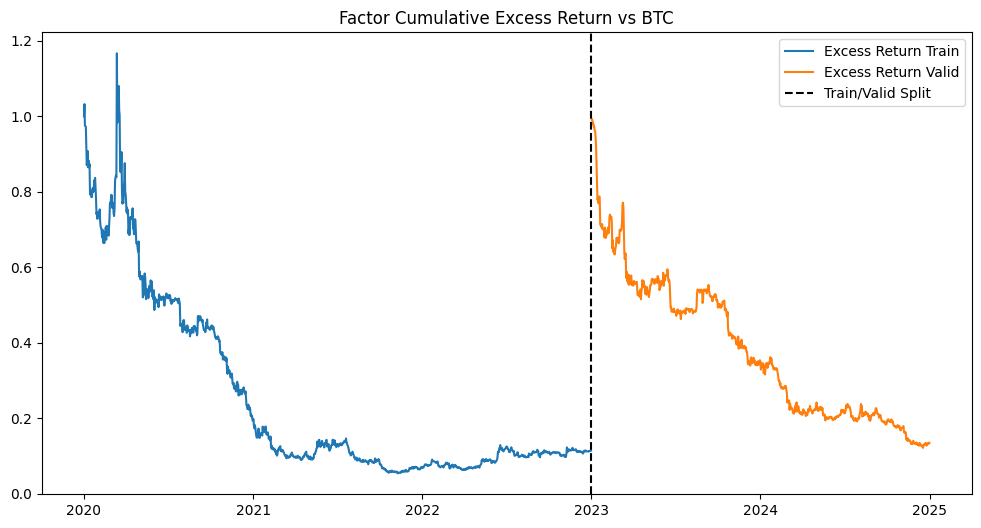

In [87]:
excess_train = net_mom_train - btc_train
excess_valid = net_mom_valid - btc_valid

excess_cum_train = (1 + excess_train.fillna(0)).cumprod()
excess_cum_valid = (1 + excess_valid.fillna(0)).cumprod()

plt.figure(figsize=(12,6))
plt.plot(excess_cum_train, label='Excess Return Train')
plt.plot(excess_cum_valid, label='Excess Return Valid')
plt.axvline(pd.to_datetime('2023-01-01'), color='black', linestyle='--', label='Train/Valid Split')
plt.title('Factor Cumulative Excess Return vs BTC')
plt.legend()
plt.show()


In [79]:
print("Assumed turnover:", 0.1)
print("Gross Train Sharpe:", sharpe(momentum_train))
print("Net Train Sharpe:", sharpe(net_mom_train))


Assumed turnover: 0.1
Gross Train Sharpe: 1.2095577149814218
Net Train Sharpe: 0.7336621791180084
